### Utilizando boto3 para processamento de Linguagem Natural 
Neste tutorial iremos utilizar ferramentas de processamento de audio e texto e Linguagem Natural para analisar dados provenientes de vídeos do Youtube. <br>
Os arquivos serão baixados utilizando uma ferramenta de linha de comando chamada [Youtube-DL](https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme), e iremos utilizar os serviços de NLP oferecidos pela AWS, accessados pela biblioteca [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

In [129]:
# Bibliotecas que serão utilizadas ao longo do tutorial
from __future__ import print_function
import boto3
import os
import time
import pandas as pd
import matplotlib as plt
import logging
from botocore.exceptions import ClientError
from datetime import date
import json

%matplotlib inline

#### 1) Baixando arquivos de vídeo do Youtube
O primeiro passo em nosso tutorial é baixar os arquivos de áudio a partir de links de videos específicos selecionados. Para isso usaremos a ferramenta Youtube-DL que pode ser instalada através do ```pip```.

```sudo pip install youtube-dl```<br>
ou<br>
```conda install -c conda-forge youtube-dl```


Para baixar um vídeo qualquer: 

```youtube-dl <video_url>```

Como iremos trabalhar apenas com áudio, podemos usar o parâmetro ```-x``` e ```--audio-format "mp3"``` para baixar somente a parte de áudio do vídeo do Youtube. 

```youtube-dl -x --audio-format "mp3" <video_url>```

#### Lista de Vídeos de selecionados
Serão analisados 5 discursos gravados em vídeo e disponibilizados publicamente no Youtube. Segue a descrição de cada um deles:

A) ["We shall never surrender" de Winston Churchill](https://www.youtube.com/watch?v=s_LncVnecLA)
Esse discurso histórico foi proferido pelo Primeiro Ministro Britânico Winston Churchill no dia 4 junho de 1940. Nele, o estadista aborda a situação crítica no qual se encontrava os aliados frente a invasão nazista na França e da batalha de Dunkirk.

B) ["40o Aniversário de Invasão da Normandia", Ronald Reagan](https://www.youtube.com/watch?v=1Leb7ynduCU)
No dia 6 de junho de 1984 Ronald Reagan, presidente americano em exercício na época, discursou na Normandia (França) em homenagem aos 40 anos do Dia-D. O discurso homenageou de forma marcante os soldados que morreram na batalha ao longo da costa norte francesa, e que de certa forma definiram o destino da Segunda Guerra, e consequentemente, da história moderna.

C) ["I have a dream", Martin Luther King](https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s)
Discurso do pastor Martin Luther King em 28 de agosto de 1963 durante a Marcha de Washington é considerado um dos mais importantes da história americana. Nele, Martin Luther King fala sobre a necessidade de se combater o racismo presente nos EUA na época e conclama uma coexistência harmoniosa em brancos e negros no futuro.

D) ["It's harder to be kind than clever", Jeff Bezos](https://www.youtube.com/watch?v=uvzkujQFlxQ)
Discurso do CEO da Amazon na formatura da Universidade de Princeton em 2010 fala sobre experiências pessoais na construção de seu caráter e decisões importantes na carreira. No momento alto do discurso Bezos diz que é mais difícil ser bom do que ser inteligente, mostrando um lado afetuoso de um dos grandes líderes de empresa da história.

E) ["Make good Art", Neil Gaiman](https://www.youtube.com/watch?v=plWexCID-kA)
Neil Gaiman coloca toda sua genialidade literária em um discurso desafiador na formatura da universidade de Artes da Filadélfia em 2012 e desafia os formandos a "fazerem boa arte" com coragem e paixão.

In [3]:
dict_urls_youtube = {
    'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
    'reagan': 'https://www.youtube.com/watch?v=1Leb7ynduCU',
    'luther_king': 'https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s',
    'bezos': 'https://www.youtube.com/watch?v=uvzkujQFlxQ',
    'gaiman': 'https://www.youtube.com/watch?v=plWexCID-kA'}

In [4]:
for url in list(dict_urls_youtube.values()):
    print(f'Baixando arquivo de áudio do link: {url}')
    os.system(f'youtube-dl -x --audio-format "mp3" {url}')

Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=s_LncVnecLA
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=1Leb7ynduCU
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=uvzkujQFlxQ
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=plWexCID-kA


In [4]:
# Criar um Dataframe para guardar as informações geradas ao longo da análise
df_audio = pd.DataFrame.from_dict(dict_urls_youtube, orient='index', columns=['youtube_urls'])
df_audio

,youtube_urls
churchill,https://www.youtube.com/watch?v=s_LncVnecLA
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ
gaiman,https://www.youtube.com/watch?v=plWexCID-kA


In [5]:
# Atribuindo nome do arquivo baixado a cada autor do discurso
for audio_file in os.listdir('.'):
    if 'churchill' in audio_file.lower():
        df_audio.at['churchill','filename'] = audio_file
    elif 'reagan' in audio_file.lower():
        df_audio.at['reagan', 'filename'] = audio_file
    elif 'king' in audio_file.lower():
        df_audio.at['luther_king', 'filename'] = audio_file
    elif 'bezos' in audio_file.lower():
        df_audio.at['bezos', 'filename'] = audio_file
    elif 'gaiman' in audio_file.lower():
        df_audio.at['gaiman', 'filename'] = audio_file

In [6]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...


### Configurando o AWS CLI pelo terminal
Para trabalhar com o boto3, você deve instalar o ```awscli```
```
$ pip install awscli --upgrade --user
```

E em seguida configurá-lo com as suas credenciais da AWS

```
aws configure
```

E definir os seguintes valores:

```
AWS Access Key ID [****************DNYA]: 
AWS Secret Access Key [****************oEG/]: 
Default region name [us-east-1]: 
Default output format [json]:
```






In [ ]:
# Definir a AZ respectiva da AWS
boto3.setup_default_session(region_name='us-east-1')

In [7]:
# Subindo os arquivos para o S3
# Criar um cliente S3
s3 = boto3.client('s3')

# Buscar lista de buckets no S3
response = s3.list_buckets()

# Organizar a resposta em uma lista
buckets = [bucket['Name'] for bucket in response['Buckets']]

for bucket in buckets:
    print(bucket)
#print("Bucket List: %s" % buckets)

aws-deepracer-35d06d75-1bdf-410f-8544-4675a95e89e2
aws-sam-cli-gsg
dnanexus-backup-gsg
elasticbeanstalk-us-east-1-089951219780
grupy-nlp-aws
little-thomas-assets
medium-lambda-tutorial-bucket
regis-media
stackery-assetsbucket-p8b8xq12o1re
udacity-secure-and-pivate-ai-project
vision-pmp


In [8]:
# Criando um novo bucket para subir os arquivos
bucket_name = 'grupy-nlp-aws'
try:
    s3 = boto3.client('s3')
    s3.create_bucket(Bucket=bucket_name)
except:
    print('Bucket com o mesmo nome já criado.')

In [ ]:
df_audio

In [11]:
df_audiobindo os arquivos de audio para o bucket s3 criado
for audio_file in df_audio.filename.values:
    print(audio_file)
    s3.upload_file(audio_file, bucket_name, audio_file)
    #boto3.resource('s3').ObjectAcl(bucket_name,audio_file).put(ACL='public-read')

WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.mp3
Normandy Speech - President Reagan's Address Commemorating 40th Anniversary of Normandy_D-Day  6_6_84-1Leb7ynduCU.mp3
I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.mp3
Amazon founder Jeff Bezos delivers speech at Princeton University - Engsub-uvzkujQFlxQ.mp3
Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.mp3


In [9]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...


In [15]:
# Definir as URLs dos arquivos no S3 em uma nova coluna no Dataframe
for index, row in df_audio.iterrows():
    bucket_location = boto3.client('s3').get_bucket_location(Bucket=bucket_name)
    object_url = f"https://{bucket_name}.s3.amazonaws.com/{row['filename'].replace(' ', '+')}"
    df_audio.at[index, 'url'] = object_url
    print(object_url)

https://grupy-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
https://grupy-nlp-aws.s3.amazonaws.com/Normandy+Speech+-+President+Reagan's+Address+Commemorating+40th+Anniversary+of+Normandy_D-Day++6_6_84-1Leb7ynduCU.mp3
https://grupy-nlp-aws.s3.amazonaws.com/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.mp3
https://grupy-nlp-aws.s3.amazonaws.com/Amazon+founder+Jeff+Bezos+delivers+speech+at+Princeton+University+-+Engsub-uvzkujQFlxQ.mp3
https://grupy-nlp-aws.s3.amazonaws.com/Neil+Gaiman+2012+Commencement+Speech+'Make+Good+Art'-plWexCID-kA.mp3


In [29]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...,https://grupy-nlp-aws.s3.amazonaws.com/Normand...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...


In [17]:
# Definir uma função para disparar o serviço Amazon Transcribe
def start_transcription(bucket, job_name, file_url, wait_process=True):
    client_transcribe = boto3.client('transcribe')
    client_transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': file_url},
        MediaFormat='mp3',
        LanguageCode='en-US',
        OutputBucketName=bucket)
    if wait_process:
        while True:
            status = client_transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(20)

        print('Transcription finished')
        return status
    

In [22]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...,https://grupy-nlp-aws.s3.amazonaws.com/Normand...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...


In [131]:
# Definir a data de hoje para usar no nome dos jobs
today = date.today().strftime("%d%m%Y")

# Iterar pelos arquivos de audio no bucket S3 e disparar os jobs no Transcribe
for index, row in df_audio.iterrows():
    print(f'{index}_speech_{today}')
    start_transcription(bucket_name, f'{index}_speech_{today}', row.url, wait_process=False)
    df_audio.at[index, 'transcription_url'] = f"https://{bucket_name}.s3.amazonaws.com/{index}_speech_{today}"
    df_audio.at[index, 'json_transcrition'] = f"{index}_speech_{today}.json"

churchill_speech_29082019
reagan_speech_29082019
luther_king_speech_29082019
bezos_speech_29082019
gaiman_speech_29082019


In [132]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcrition
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...,https://grupy-nlp-aws.s3.amazonaws.com/churchi...,churchill_speech_29082019.json
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...,https://grupy-nlp-aws.s3.amazonaws.com/Normand...,https://grupy-nlp-aws.s3.amazonaws.com/reagan_...,reagan_speech_29082019.json
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...,https://grupy-nlp-aws.s3.amazonaws.com/luther_...,luther_king_speech_29082019.json
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...,https://grupy-nlp-aws.s3.amazonaws.com/bezos_s...,bezos_speech_29082019.json
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...,https://grupy-nlp-aws.s3.amazonaws.com/gaiman_...,gaiman_speech_29082019.json


In [32]:
# Verificar os jobs do Amazon Transcribe que estão com o Status COMPLETED
client_transcribe = boto3.client('transcribe')
response_transcribe = client_transcribe.list_transcription_jobs(
    Status='COMPLETED')
response_transcribe

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs9w2RWNhpdyVNX6AXq87WJO3tmrjnhME3D8VLKCsKotw3jMJUBWzGWAUjx/PONNqJeda9KqJLMUIh6pprwxVdN47TKNgRLqpxMuJUzl+Xe1Hd9Lx7eg3LzHujCZnsNFrPUf84hA7pvqEoDcfvpaLoD+N3rTrYKtO9RH1x9abd8iLhyugQFwyMn4l4Ab7idr/7/zDRxNIIc7e/X+JhTDUjDs/8pZUDl46HDo4huUkPR2ioblCWsTwxEgG2o5Xn1Mi54uI3EjLeM/gfSQn9fRiKoA65vIt1CKXRfghURJrx3iiT95pvFOMwg05keD1u7nbA8GMHkzwI+W4yVJzenHLWTUUkXaYVJvFUuiq/gQD1r3H/LLsen5wy5I8Yf5wPTYaNwRMJaNWHTWYyqCHnZDsb6sho8ZaDwMnfQo4mX/aCDUO9w4/zLAQBPOtNEmccBHkIAcXZmHY/q7oBkX/SSCdXGWecKSJgL1fIMkFtAct3oystMBneko1fzn4oyBh01nn1mfyiu2nLtTuS2jP+inXRzAbhu+15pO089ypWgWdE3ZaePVlpCpz2hwW2/8ICMNM2ftUQsCJbZAPupI/YcZCTsVvn0HGJSEmLq9/nut2ctanYNtsw2ZhLBR9Mwxa8V/aArNTPjhfMuyqHdVWyOnx7WlyHIeWbBZ4Co70K5ZlzE1xgqqMz9XL/uz0X4ofZYv0jZg3M4aAvYal9Cox/SLSii3MLo6XJ2NNg1Uq9mtPM9QB2zV0tlgYq0LUS4Ir10VkNaGQGD43wPdoXN1cRPGS037ONm4GOPDNqbdQAUnpZXURRldYddjUkQ3e4xprF/zTFOm27Irh',
 'TranscriptionJobSummaries': [{'TranscriptionJobNam

In [37]:
client_transcribe = boto3.client('transcribe')
response_transcribe_job = client_transcribe.get_transcription_job(
    TranscriptionJobName= f'churchill_speech_{today}'
)
response_transcribe_job

{'TranscriptionJob': {'TranscriptionJobName': 'churchill_speech_28082019',
  'TranscriptionJobStatus': 'COMPLETED',
  'LanguageCode': 'en-US',
  'MediaSampleRateHertz': 44100,
  'MediaFormat': 'mp3',
  'Media': {'MediaFileUri': 'https://grupy-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3'},
  'Transcript': {'TranscriptFileUri': 'https://s3.amazonaws.com/grupy-nlp-aws/churchill_speech_28082019.json'},
  'CreationTime': datetime.datetime(2019, 8, 28, 23, 10, 25, 966000, tzinfo=tzlocal()),
  'CompletionTime': datetime.datetime(2019, 8, 28, 23, 13, 33, 922000, tzinfo=tzlocal()),
  'Settings': {'ChannelIdentification': False}},
 'ResponseMetadata': {'RequestId': '635a7130-b647-42c8-b017-11a138dc4de5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Aug 2019 02:20:32 GMT',
   'x-amzn-requestid': '635a7130-b647-42c8-b017-11a138dc4de5',
   'content-length

In [41]:
df_audio.transcription_url.to_list()

['https://grupy-nlp-aws.s3.amazonaws.com/churchill_speech_28082019',
 'https://grupy-nlp-aws.s3.amazonaws.com/reagan_speech_28082019',
 'https://grupy-nlp-aws.s3.amazonaws.com/luther_king_speech_28082019',
 'https://grupy-nlp-aws.s3.amazonaws.com/bezos_speech_28082019',
 'https://grupy-nlp-aws.s3.amazonaws.com/gaiman_speech_28082019']

In [138]:
# Função para de baixar o texto transcrito de um Json no S3
def get_text_from_json(bucket, key):
    s3 = boto3.client('s3')
    object = s3.get_object(Bucket=bucket, Key=key)
    serializedObject = object['Body'].read()
    data = json.loads(serializedObject)
    return data.get('results').get('transcripts')[0].get('transcript')

In [140]:
len(get_text_from_json(bucket_name, df_audio.loc['gaiman', 'json_transcrition']))

15796

In [141]:
# Para listar os jobs executados no Amazon Transcribe
transcribe_client = boto3.client('transcribe')
response = transcribe_client.list_transcription_jobs(
    Status='COMPLETED')
response

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs9w2RWNhpdyVNX6AXq87WJO3tmrjnhME3D8VLKCsKotw3jMJUBWzGWAUjx/PONNqJeda9KqJLMUIh6pprwxVdN47TKNgRLqpxMuJUzl+Xe1Hd9Lx7eg3LzHujCZnsNFrPUf84hA7pvqEoDcfvpaLoD+N3rTrYKtO9RH1x9abd8iLhyugQFwyMn4l4Ab7idr/7/zDRxNIIc7e/X+JhTDUjDs/8pZUDl46HDo4huUkPR2ioblCWsTwxEgG2o5Xn1Mi54uI3EjLeM/gfSQn9fRiKoA65vIt1CKXRfghURJrx3iiT95pvFOMwg05keD1u7nbA8GMHkzwI+W4yVJzenHLWTUUkXaYVJvFUuiq/gQD1r3H/LLsen5wy5I8Yf5wPTYcD89YBlWLxXKcdXOe49a0STbAnqFp7JKQNsY34tYQIsEgyDBMJPUBrvxLseklAXBVkEvp+M6ppv+FSp7QPevCHbPhXxLKy9SMNzHfcmzCgUTh2REWK+heN2s1iJymP2SMHyM2A/abER3b/UonQG6ZkTOF/fFcLz9VISrmk1q5hM3Cj1d6JG1FU5SJ9HcIplDBX9sYCimuxVAP0jFbBpqYTrQGIErd5jfhK0a9eDmV2Mrth69CDByAVdrFPq9qrvsJ4PL02ZYsRD+Z8cKxn2PUaxH5upnmt1v1+OPrkz/Dw/0EPCriR7OJdH40wQ+lDuPrG1ar2QF5ZejcMopUqvffPxecLl7LU/KV89XEk9gzwP7P9WA+SLnNo+mOfWm+dVWR3zWY8EKIGBc90bFf2wsnvFYQH3yQ4XQRRMkk1/054tQJF52Ytu/viDumCdOmXLzrpul/qNnC',
 'TranscriptionJobSummaries': [{'TranscriptionJobNam

In [127]:
def start_comprehend_job(text):
    list_parts = []
    text_for_analysis = ''
    for sentence in text.split('.'):
        current_text = text_for_analysis + f'{sentence}.'

        if len(current_text.encode('utf-8')) > 5000:
            list_parts.append([len(text_for_analysis), text_for_analysis])
            text_for_analysis = f'{sentence}.'

        else:
            text_for_analysis += f'{sentence}.'

    list_parts.append([len(text_for_analysis), text_for_analysis])
    dict_comprehend = {}
    for t_parts in list_parts:
        comprehend_client = boto3.client(service_name='comprehend', region_name='us-east-1')
        sentimentData = comprehend_client.detect_sentiment(Text=t_parts[1], LanguageCode='en')
        dict_comprehend[t_parts[0]] = sentimentData
        dict_comprehend[t_parts[0]]['ratio'] = t_parts[0]/float(len(text))

    final_dict = {'Positive':0, 'Negative':0, 'Neutral':0, 'Mixed':0}
    list_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']
    for sentiment in list_sentiments:
        for key, value in dict_comprehend.items():
            final_dict[sentiment] += value.get('SentimentScore').get(sentiment) * value.get('ratio')
    
    return final_dict

In [142]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcrition
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...,https://grupy-nlp-aws.s3.amazonaws.com/churchi...,churchill_speech_29082019.json
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...,https://grupy-nlp-aws.s3.amazonaws.com/Normand...,https://grupy-nlp-aws.s3.amazonaws.com/reagan_...,reagan_speech_29082019.json
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...,https://grupy-nlp-aws.s3.amazonaws.com/luther_...,luther_king_speech_29082019.json
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...,https://grupy-nlp-aws.s3.amazonaws.com/bezos_s...,bezos_speech_29082019.json
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...,https://grupy-nlp-aws.s3.amazonaws.com/gaiman_...,gaiman_speech_29082019.json


In [143]:
# Gerar a análise de sentimento usando o Amazon Comprehend
for index, row in df_audio.iterrows():
    transcript_text = get_text_from_json(bucket_name, row.json_transcrition)
    comprehend_results = start_comprehend_job(transcript_text)
    for k,v in comprehend_results.items():
        df_audio.at[index, k] = v
    
    
    

In [144]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcrition,Positive,Negative,Neutral,Mixed
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...,https://grupy-nlp-aws.s3.amazonaws.com/churchi...,churchill_speech_29082019.json,0.276516,0.064977,0.523759,0.134878
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...,https://grupy-nlp-aws.s3.amazonaws.com/Normand...,https://grupy-nlp-aws.s3.amazonaws.com/reagan_...,reagan_speech_29082019.json,0.241181,0.005791,0.719546,0.033668
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...,https://grupy-nlp-aws.s3.amazonaws.com/luther_...,luther_king_speech_29082019.json,0.343839,0.005916,0.594401,0.056180
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...,https://grupy-nlp-aws.s3.amazonaws.com/bezos_s...,bezos_speech_29082019.json,0.527087,0.015820,0.390241,0.066992
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...,https://grupy-nlp-aws.s3.amazonaws.com/gaiman_...,gaiman_speech_29082019.json,0.461380,0.147436,0.235781,0.155467


In [25]:
## Visualização do resultado da análise de sentimento dos discursos

In [145]:
df_audio_radar = df_audio[['Positive','Negative','Neutral','Mixed']]

In [147]:
df = df_audio_radar

In [150]:
df2 = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
df2

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


In [149]:
df

,Positive,Negative,Neutral,Mixed
churchill,0.276516,0.064977,0.523759,0.134878
reagan,0.241181,0.005791,0.719546,0.033668
luther_king,0.343839,0.005916,0.594401,0.056180
bezos,0.527087,0.015820,0.390241,0.066992
gaiman,0.461380,0.147436,0.235781,0.155467


In [156]:
categories=list(df)[:]
categories

['Positive', 'Negative', 'Neutral', 'Mixed']

In [158]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
"""
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
"""
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):
    # number of variable
    categories=list(df)[:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)

    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
#for row in range(0, len(df.index)):
for index, row in df.iterrows():

    make_spider( row=row, title='group '+index, color=my_palette(row))


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1000x1000 with 0 Axes>

In [26]:
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LabelSet

num_vars = 9

theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
# rotate theta such that the first axis is at the top
theta += np.pi/2

def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.
    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

def radar_patch(r, theta):
    yt = (r + 0.01) * np.sin(theta) + 0.5
    xt = (r + 0.01) * np.cos(theta) + 0.5
    return xt, yt

verts = unit_poly_verts(theta)
x = [v[0] for v in verts] 
y = [v[1] for v in verts] 

p = figure(title="Radar")
text = ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3']
source = ColumnDataSource({'x':x+ [0.5],'y':y+ [1],'text':text})

p.line(x="x", y="y", source=source)

labels = LabelSet(x="x",y="y",text="text",source=source)

p.add_layout(labels)

# example factor:
f1 = np.array([0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00]) * 0.5
f2 = np.array([0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00]) * 0.5
f3 = np.array([0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00]) * 0.5
f4 = np.array([0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00]) * 0.5
f5 = np.array([0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]) * 0.5
#xt = np.array(x)
flist = [f1,f2,f3,f4,f5]
colors = ['blue','green','red', 'orange','purple']
for i in range(len(flist)):
    xt, yt = radar_patch(flist[i], theta)
    p.patch(x=xt, y=yt, fill_alpha=0.15, fill_color=colors[i])
show(p)

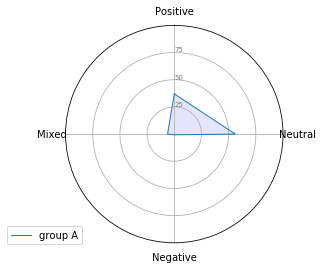

In [74]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
"""
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
"""
df = pd.DataFrame({
    'group': ['MLK'],
    'Positive': [0.36963951587677],
    'Neutral': [0.5614382028579712],
    'Negative': [0.006769296247512102],
    'Mixed':[0.06215296685695648]})
#""" 
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["25","50","75"], color="grey", size=7)
plt.ylim(0,1)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
#values=df.loc[1].drop('group').values.flatten().tolist()
#values += values[:1]
#ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
#ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


In [69]:
categories

['var1', 'var2', 'var3', 'var4', 'var5']

Bibliografia e Links
* Tutorial de reconhecimento de audio em Python https://realpython.com/python-speech-recognition/
* Tutorial de como baixar videos do Youtube usando linha de comando no Linux https://itsfoss.com/download-youtube-linux/
* Projeto Youtube-DL https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme
* Discurso “We Shall Fight on the Beaches” de Winston Churchill https://www.artofmanliness.com/we-shall-fight-on-the-beaches-by-winston-churchill/
* Discurso “40th Anniversary of D-Day” de Ronald Regan https://www.artofmanliness.com/40th-anniversary-of-d-day-by-ronald-regan/ https://www.youtube.com/watch?v=eEIqdcHbc8I
* Discurso "I Have a Dream" de Martin Luther King https://kinginstitute.stanford.edu/king-papers/documents/i-have-dream-address-delivered-march-washington-jobs-and-freedom
* Discurso “What Matters More Than Your Talents” de Jeff Bezos https://jamesclear.com/great-speeches/what-matters-more-than-your-talents-by-jeff-bezos
* Discurso “Make Good Art” de Neil Gaiman https://jamesclear.com/great-speeches/make-good-art-by-neil-gaiman
* Tutorial de configuração de conta AWS e boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#using-boto-3
* Tutorial de como lidar com Json no Python https://realpython.com/python-json/
* Curso de 'Natural Language Processing Fundamentals in Python' do DataCamp https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python